## spike waveform clustering

1. Find all data files in a directory and return the path and filenames

1. Read matlab data and obtain its unit name and average waveform

1. Concatenate all files together

1. Normalize waveforms within itself by its largest values

1. Perform clustering training and prediction

1. Return the unit name and corresponding spike class

In [1]:
# import required modules
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context("talk")
sns.set_style("whitegrid")
import pdb
import scipy
from ipywidgets import interact, interactive, fixed
from scipy.stats import multivariate_normal
from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import AffinityPropagation, MiniBatchKMeans, KMeans, SpectralClustering
from sklearn import metrics
from sklearn.manifold import TSNE

# simplegui
from Tkinter import *
import Tkinter
from tkFileDialog import askopenfilename
default_figsize = (10, 8)

# for importing customized figures
import sys
import mdlab as mdl

In [2]:
def pca_spike_waveform(spike_waveforms, num_components=None):
    """
    use PCA to reduce the dimension of the spikewaveform
    :param spike_waveforms:
    :param num_components:
    :return:
    """
    pca = PCA(n_components=num_components)
    pca.fit(spike_waveforms)
    representations = pca.transform(spike_waveforms)
    print(pca.explained_variance_ratio_)
    return (representations)

def spike_clustering(spike_waveforms, num_clusters=2):
#     af = AffinityPropagation()
    af = MiniBatchKMeans(n_clusters=2)
#     af = KMeans(n_clusters=num_clusters)
#     af = SpectralClustering(n_clusters=2)
    labels = af.fit_predict(spike_waveforms)
    return(labels)

def code2label(labels, code_label_dict):
    new_labels = [code_label_dict[item] for item in labels]
    return(np.asarray(new_labels))

## list, read, and concatenate the spike waveforms from .npz data

In [3]:
npz_files = mdl.list_files(".*\.npz")
npz_files

[u'C:/Users/Vicario_lab/Documents/Mingwen_data_analysis/2018_Dissertation/SpikeWaveforms/alternating_1sec.npz',
 u'C:/Users/Vicario_lab/Documents/Mingwen_data_analysis/2018_Dissertation/SpikeWaveforms/alternating_3sec.npz',
 u'C:/Users/Vicario_lab/Documents/Mingwen_data_analysis/2018_Dissertation/SpikeWaveforms/alternating_jittered.npz',
 u'C:/Users/Vicario_lab/Documents/Mingwen_data_analysis/2018_Dissertation/SpikeWaveforms/blocked.npz',
 u'C:/Users/Vicario_lab/Documents/Mingwen_data_analysis/2018_Dissertation/SpikeWaveforms/contrast.npz',
 u'C:/Users/Vicario_lab/Documents/Mingwen_data_analysis/2018_Dissertation/SpikeWaveforms/control_1sec.npz',
 u'C:/Users/Vicario_lab/Documents/Mingwen_data_analysis/2018_Dissertation/SpikeWaveforms/control_3sec.npz',
 u'C:/Users/Vicario_lab/Documents/Mingwen_data_analysis/2018_Dissertation/SpikeWaveforms/control_jittered.npz',
 u'C:/Users/Vicario_lab/Documents/Mingwen_data_analysis/2018_Dissertation/SpikeWaveforms/oddball_jittered.npz',
 u'C:/Users/V

check whether all .npz files have spikewaveform information

In [4]:
for fn in npz_files:
    data = np.load(fn)
    print(data.keys())

['spike_waveforms', 'spikes', 'spike_ids', 'filenames', 'stim_waveforms', 'header', 'spike_condtions']
['spike_waveforms', 'spikes', 'spike_ids', 'filenames', 'stim_waveforms', 'header', 'spike_condtions']
['spike_waveforms', 'spikes', 'spike_ids', 'filenames', 'stim_waveforms', 'header', 'spike_condtions']
['spike_waveforms', 'spikes', 'spike_ids', 'filenames', 'stim_waveforms', 'header', 'spike_condtions']
['spike_waveforms', 'spikes', 'spike_ids', 'filenames', 'stim_waveforms', 'header', 'spike_condtions']
['spike_waveforms', 'spikes', 'spike_ids', 'filenames', 'stim_waveforms', 'header', 'spike_condtions']
['spike_waveforms', 'spikes', 'spike_ids', 'filenames', 'stim_waveforms', 'header', 'spike_condtions']
['spike_waveforms', 'spikes', 'spike_ids', 'filenames', 'stim_waveforms', 'header', 'spike_condtions']
['spike_waveforms', 'spikes', 'spike_ids', 'filenames', 'stim_waveforms', 'header', 'spike_condtions']
['spike_waveforms', 'spikes', 'spike_ids', 'filenames', 'stim_waveforms',

remove bad units (with nan values), label SUA with condition, bird, and electrode

In [13]:
path_separator = "/"  # depending on the operating system, this is what Windows uses
spike_waveform_list = []  # 
header_list = []
condition_list = []
id_list = []
for fn in npz_files:
    tmp_data = np.load(fn)
    # !!! spike_condtions is a typo, it will be corrected in the future release of mdlab, 
    # one needs to change this key in the future !!!
    tmp_cnd, tmp_id, tmp_sw = data["spike_condtions"], data["spike_ids"], data["spike_waveforms"]
    for i in range(len(tmp_cnd)):
        unit_id = tmp_id[i]
        birdid, unit = unit_id.split(mdl.separator)
        unit_sw = tmp_sw[i]
        
        sua_label = int(unit) % mdl.mua_sua_distinguisher != 0  # whether the current channel is SUA?
        valid_value = not np.any(np.isnan(unit_sw))  # whether spikewaveform contains any nan
        
        if sua_label and valid_value: # only include single-unit, SUA cannot be divided exactly by 100.
            
            unit_cnd = fn.split("/")[-1][:-4]
            unit_header = tmp_cnd[i]
            
            condition_list.append(unit_cnd)
            id_list.append(unit_id)
            header_list.append(unit_header)
            spike_waveform_list.append(unit_sw)
spike_waveform_list = np.asarray(spike_waveform_list)

# summary whether there are potential errors: all lists/arrays should have the same number of items
print("----------------------------------------------------------------------------------------------------")
print(len(spike_waveform_list), len(condition_list), len(id_list), len(header_list))
print("----------------------------------------------------------------------------------------------------")

----------------------------------------------------------------------------------------------------
(2960, 2960, 2960, 2960)
----------------------------------------------------------------------------------------------------


## normalize the waveform within itself

In [14]:
spike_waveform_list = spike_waveform_list / np.max(spike_waveform_list, axis=1)[:, np.newaxis]

## PCA to reduce the dimension of the data

In [15]:
new_representations = pca_spike_waveform(spike_waveform_list, num_components=4)
# sw_embedded = TSNE(n_components=2).fit_transform(spike_waveform_list)

[0.59752532 0.22814403 0.09259192 0.04477847]


## perform clustering using KMeans, affinity propagation, or other

Silhouette Coefficient: 0.616


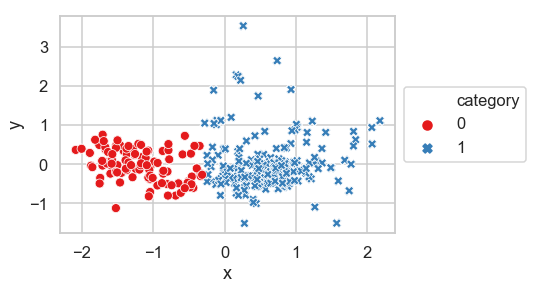

In [16]:
labels = spike_clustering(new_representations)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(new_representations, labels, metric='sqeuclidean'))
mdl.categorical_scatterplot(x=new_representations[:, 0], y=new_representations[:, 1], categories=labels)

In [17]:
# mdl.categorical_scatterplot(x=sw_embedded[:, 0], y=sw_embedded[:, 1], categories=labels)

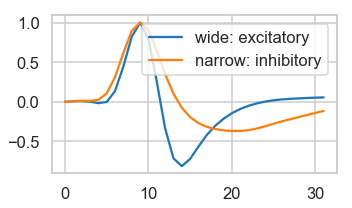

In [18]:
wav_idx = labels == 0
opp_idx = np.logical_not(wav_idx)
class_1 = spike_waveform_list[wav_idx].mean(axis=0)
class_2 = spike_waveform_list[opp_idx].mean(axis=0)
plt.figure(figsize=(5, 3))
plt.plot(class_1)
plt.plot(class_2)
plt.legend(["wide: excitatory", "narrow: inhibitory"])
code_label_dict = {0: "wide", 1: "narrow"} # defined after plotting the average waveform
plt.tight_layout()
labels = code2label(labels, code_label_dict)
# plt.savefig("narrow_vs_wide.png", dpi=600)

In [19]:
df = pd.DataFrame({"filename": header_list, 
                   "label": labels, 
                   "condition": condition_list,
                   "id": id_list
                  })

## save clustering results

In [22]:
df.sample(15)

,condition,filename,id,label
1623,control_1sec,matrix_NB007__shuffled_.mat,NB007___1902,narrow
1514,control_1sec,matrix_NB002__shuffled_.mat,NB002___1002,narrow
2040,control_3sec,matrix_WE100__shuffled_.mat,WE100___2103,wide
514,alternating_3sec,matrix_WE084__shuffled_.mat,WE084___1302,narrow
2546,oddball_jittered,matrix_WE067__shuffled_.mat,WE067___102,narrow
890,blocked,matrix_NB001__shuffled_.mat,NB001___2702,narrow
1025,blocked,matrix_NB007__shuffled_.mat,NB007___2702,narrow
540,alternating_3sec,matrix_WE094__shuffled_.mat,WE094___2503,narrow
772,alternating_jittered,matrix_WE067__shuffled_.mat,WE067___2502,narrow
2111,control_jittered,matrix_NB002__shuffled_.mat,NB002___501,narrow


In [23]:
csv_filename = "sua_dict.csv"
df.to_csv(csv_filename, index=False)